# Unsupervised Learning Trading Strategy

- Download S&P 500 Stock Data
- Calculate indicators on each stock
- Aggregate the data to a monthly level and filter for the top 150 most liquid stocks
- Calculate monthly returns
- Calculate rolling factor betas
- Fit a K-Means Clustering Algorithm to group similar stocks
- Visualize Portfolio returns and compare to S&P 500 returns

# 1. Download S&P 500 Data

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

tickerList = sp500['Symbol'].unique().tolist()
tickerList.remove('VLTO')
tickerList.remove('PPL')

endDate = '2023-08-28'

startDate = pd.to_datetime(endDate)-pd.DateOffset(365*8)

df = yf.download(tickers=tickerList, start=startDate, end=endDate).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  501 of 501 completed


adj close       close        high         low        open  \
date       ticker                                                               
2015-08-31 A        33.895737   36.310001   36.549999   35.950001   36.439999   
           AAL      37.170906   38.980000   39.759998   38.619999   38.630001   
           AAPL     25.588263   28.190001   28.632500   28.000000   28.007500   
           ABBV     43.771679   62.410000   64.309998   62.250000   64.139999   
           ABT      38.762821   45.290001   46.630001   45.119999   45.910000   
...                       ...         ...         ...         ...         ...   
2023-08-25 YUM     129.135010  129.740005  130.880005  129.630005  130.339996   
           ZBH     114.990288  115.239998  115.779999  114.160004  114.580002   
           ZBRA    268.390015  268.390015  269.470001  264.450012  267.899994   
           ZION     34.130001   34.130001   35.000000   33.750000   34.639999   
           ZTS     182.383331  182.820007  185.009995  181.440002  183.080002   

                        volume  
date       ticker               
2015-08-31 A         2554700.0  
           AAL      12409600.0  
           AAPL    224917200.0  
           ABBV     15581100.0  
           ABT       7470200.0  
...                        ...  
2023-08-25 YUM       1097300.0  
           ZBH       1456700.0  
           ZBRA       337300.0  
           ZION      1423500.0  
           ZTS        879700.0  

[991195 rows x 6 columns]

# 2. Calculate Technical Indicators

* Garman-Klass Volatility (GKV)
* Relative Strength Index (RSI)
* Bollinger Bands (BOLU - Upper Band, BOLD - Lower Band, and BOLM - Middle)
* Average True Range (ATR)
* Moving Average Convergence/Divergence (MACD)
* Dollar Volume (DVol)

In [2]:
df['GKV'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['RSI'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['BOLD'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['BOLM'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['BOLU'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def computeATR(data):
    atr = pandas_ta.atr(high=data['high'], low=data['low'], close=data['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['ATR'] = df.groupby(level=1, group_keys=False).apply(computeATR)

def computeMACD(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['MACD'] = df.groupby(level=1, group_keys=False)['adj close'].apply(computeMACD)

df['DVol'] = ((df['adj close']*df['volume'])/1e6)

df

adj close       close        high         low        open  \
date       ticker                                                               
2015-08-31 A        33.895737   36.310001   36.549999   35.950001   36.439999   
           AAL      37.170906   38.980000   39.759998   38.619999   38.630001   
           AAPL     25.588263   28.190001   28.632500   28.000000   28.007500   
           ABBV     43.771679   62.410000   64.309998   62.250000   64.139999   
           ABT      38.762821   45.290001   46.630001   45.119999   45.910000   
...                       ...         ...         ...         ...         ...   
2023-08-25 YUM     129.135010  129.740005  130.880005  129.630005  130.339996   
           ZBH     114.990288  115.239998  115.779999  114.160004  114.580002   
           ZBRA    268.390015  268.390015  269.470001  264.450012  267.899994   
           ZION     34.130001   34.130001   35.000000   33.750000   34.639999   
           ZTS     182.383331  182.820007  185.009995  181.440002  183.080002   

                        volume       GKV        RSI      BOLD      BOLM  \
date       ticker                                                         
2015-08-31 A         2554700.0 -0.001887        NaN       NaN       NaN   
           AAL      12409600.0 -0.000150        NaN       NaN       NaN   
           AAPL    224917200.0 -0.002903        NaN       NaN       NaN   
           ABBV     15581100.0 -0.055864        NaN       NaN       NaN   
           ABT       7470200.0 -0.010520        NaN       NaN       NaN   
...                        ...       ...        ...       ...       ...   
2023-08-25 YUM       1097300.0  0.000013  39.087357  4.850259  4.891177   
           ZBH       1456700.0  0.000094  23.551282  4.724972  4.817744   
           ZBRA       337300.0  0.000176  46.527955  5.477007  5.574559   
           ZION      1423500.0  0.000576  50.073548  3.528315  3.609511   
           ZTS        879700.0  0.000184  52.220881  5.181331  5.221831   

                       BOLU       ATR      MACD         DVol  
date       ticker                                             
2015-08-31 A            NaN       NaN       NaN    86.593439  
           AAL          NaN       NaN       NaN   461.276076  
           AAPL         NaN       NaN       NaN  5755.240367  
           ABBV         NaN       NaN       NaN   682.010906  
           ABT          NaN       NaN       NaN   289.566027  
...                     ...       ...       ...          ...  
2023-08-25 YUM     4.932094  0.021227 -1.446674   141.699846  
           ZBH     4.910517 -0.430309 -2.470100   167.506352  
           ZBRA    5.672112  0.344780 -0.670522    90.527952  
           ZION    3.690707  0.221847  0.033726    48.584057  
           ZTS     5.262332  0.852844  0.205937   160.442617  

[991195 rows x 14 columns]

# 3. Aggregate data to monthly level and filter for top 150 most liquid stocks

This was done to reduce training time.

In [3]:
cols = [c for c in df.columns.unique(0) if c not in ['DVol', 'volume', 'open', 'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['DVol'].resample('M').mean().stack('ticker').to_frame('DVol'), 
df.unstack()[cols].resample('M').last().stack('ticker')], axis=1)).dropna()

data

DVol       ATR      BOLD      BOLM      BOLU  \
date       ticker                                                        
2015-10-31 A         81.152730 -1.118568  3.508661  3.552740  3.596820   
           AAL      435.685798  0.945751  3.639333  3.753168  3.867002   
           AAPL    5217.326861 -0.882671  3.231976  3.288048  3.344120   
           ABBV     459.500813  0.499258  3.589464  3.674637  3.759811   
           ABT      285.804816 -0.863485  3.550584  3.621773  3.692962   
...                        ...       ...       ...       ...       ...   
2023-08-31 YUM      189.719925  0.021227  4.850259  4.891177  4.932094   
           ZBH      209.976946 -0.430309  4.724972  4.817744  4.910517   
           ZBRA     160.467976  0.344780  5.477007  5.574559  5.672112   
           ZION      89.668069  0.221847  3.528315  3.609511  3.690707   
           ZTS      318.595268  0.852844  5.181331  5.221831  5.262332   

                        GKV      MACD        RSI   adj close  
date       ticker                                             
2015-10-31 A      -0.001563  0.122534  62.432062   35.351635  
           AAL    -0.000287  1.575246  64.446681   44.074894  
           AAPL   -0.004500 -0.085134  60.235941   27.117746  
           ABBV   -0.037457 -0.543432  58.062049   42.151264  
           ABT    -0.009622  0.265697  61.101158   38.566097  
...                     ...       ...        ...         ...  
2023-08-31 YUM     0.000013 -1.446674  39.087357  129.135010  
           ZBH     0.000094 -2.470100  23.551282  114.990288  
           ZBRA    0.000176 -0.670522  46.527955  268.390015  
           ZION    0.000576  0.033726  50.073548   34.130001  
           ZTS     0.000184  0.205937  52.220881  182.383331  

[46823 rows x 9 columns]

- Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [4]:
data['DVol'] = (data.loc[:, 'DVol'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['DVolRank']= (data.groupby('date')['DVol'].rank(ascending=False))

data = data[data['DVolRank']<150].drop(['DVol', 'DVolRank'], axis=1)

data

ATR      BOLD      BOLM      BOLU       GKV      MACD  \
date       ticker                                                               
2016-09-30 AAL    -0.031260  3.517487  3.587081  3.656676  0.000336  0.007428   
           AAPL   -0.991397  3.223032  3.285753  3.348474 -0.001820 -0.077850   
           ABBV   -1.361643  3.840018  3.861411  3.882804 -0.037145 -0.365014   
           ABT    -1.054674  3.603281  3.626671  3.650061 -0.005227 -0.365973   
           ACN    -0.711158  4.564115  4.624050  4.683986 -0.005061  0.122864   
...                     ...       ...       ...       ...       ...       ...   
2023-08-31 VRTX    0.257434  5.832888  5.854820  5.876751  0.000111 -0.245341   
           VZ     -0.929917  3.489523  3.510432  3.531341 -0.000050 -0.466071   
           WFC    -0.686411  3.720404  3.784598  3.848792  0.000175 -0.790312   
           WMT     0.374202  5.056361  5.073312  5.090263  0.000039 -0.139754   
           XOM     1.031891  4.657008  4.688403  4.719798  0.000207  0.508532   

                         RSI   adj close  
date       ticker                         
2016-09-30 AAL     53.869411   35.288372  
           AAPL    59.146381   26.202568  
           ABBV    43.768493   45.945011  
           ABT     50.322564   37.085949  
           ACN     68.571153  108.544647  
...                      ...         ...  
2023-08-31 VRTX    51.813124  350.059998  
           VZ      46.263547   32.653023  
           WFC     38.658628   40.865685  
           WMT     51.897266  157.820007  
           XOM     53.728581  108.250000  

[12516 rows x 8 columns]

# 4. Calculate Monthly Returns for Different Time Horizons

In [5]:
def calcReturn(df):
    
    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'Return {lag}M'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
        
    return df

data = data.groupby(level=1, group_keys=False).apply(calcReturn).dropna()

data

ATR      BOLD      BOLM      BOLU       GKV      MACD  \
date       ticker                                                               
2017-09-30 AAL     0.479254  3.764263  3.820264  3.876266 -0.000215  0.355354   
           AAPL   -0.888573  3.594099  3.641887  3.689675 -0.000959 -0.463601   
           ABBV   -0.269061  4.077986  4.179889  4.281793 -0.029421  1.298387   
           ABT    -0.954573  3.840507  3.866347  3.892186 -0.004815  0.382217   
           ACN    -0.870694  4.782229  4.817739  4.853250 -0.004568  0.194664   
...                     ...       ...       ...       ...       ...       ...   
2023-08-31 VRTX    0.257434  5.832888  5.854820  5.876751  0.000111 -0.245341   
           VZ     -0.929917  3.489523  3.510432  3.531341 -0.000050 -0.466071   
           WFC    -0.686411  3.720404  3.784598  3.848792  0.000175 -0.790312   
           WMT     0.374202  5.056361  5.073312  5.090263  0.000039 -0.139754   
           XOM     1.031891  4.657008  4.688403  4.719798  0.000207  0.508532   

                         RSI   adj close  Return 1M  Return 2M  Return 3M  \
date       ticker                                                           
2017-09-30 AAL     53.050778   46.185772   0.061466  -0.028700  -0.018447   
           AAPL    45.768816   36.351837  -0.060244   0.019956   0.024187   
           ABBV    70.568569   67.243988   0.180080   0.125265   0.073326   
           ABT     63.664970   47.949158   0.047507   0.041630   0.033465   
           ACN     56.250165  122.512268   0.032961   0.023971   0.029801   
...                      ...         ...        ...        ...        ...   
2023-08-31 VRTX    51.813124  350.059998  -0.006471  -0.002632   0.026577   
           VZ      46.263547   32.653023  -0.021420  -0.044595  -0.016000   
           WFC     38.658628   40.865685  -0.099817  -0.013298   0.014382   
           WMT     51.897266  157.820007  -0.009252   0.003813   0.025471   
           XOM     53.728581  108.250000   0.017693   0.008761   0.022200   

                   Return 6M  Return 9M  Return 12M  
date       ticker                                    
2017-09-30 AAL      0.020186   0.002602    0.022680  
           AAPL     0.013139   0.033672    0.027658  
           ABBV     0.056376   0.042995    0.032249  
           ABT      0.033071   0.039285    0.021639  
           ACN      0.021839   0.017126    0.010139  
...                      ...        ...         ...  
2023-08-31 VRTX     0.031696   0.011296    0.018252  
           VZ      -0.019387  -0.011734   -0.013213  
           WFC     -0.018247  -0.014237   -0.002501  
           WMT      0.019546   0.005572    0.015933  
           XOM      0.000264  -0.000408    0.013158  

[10343 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas

- Fama-French Factors: Market risk, size, value, operating profitability and investment
- These factors are used to estimate exposure of stocks to common risks using linear regression
- They explain asset returns and are used to assess risk/return

In [6]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['Return 1M']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  Return 1M
date       ticker                                                   
2017-09-30 AAL     0.0251  0.0478  0.0314 -0.0147  0.0169   0.061466
           AAPL    0.0251  0.0478  0.0314 -0.0147  0.0169  -0.060244
           ABBV    0.0251  0.0478  0.0314 -0.0147  0.0169   0.180080
           ABT     0.0251  0.0478  0.0314 -0.0147  0.0169   0.047507
           ACN     0.0251  0.0478  0.0314 -0.0147  0.0169   0.032961
...                   ...     ...     ...     ...     ...        ...
2023-08-31 VRTX   -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.006471
           VZ     -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.021420
           WFC    -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.099817
           WMT    -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.009252
           XOM    -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.017693

[10343 rows x 6 columns]

- Filter out stocks that have less than 10 months of data

In [7]:
allStocks = factor_data.groupby(level=1).size()

validStocks = allStocks[allStocks >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(validStocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  Return 1M
date       ticker                                                   
2017-09-30 AAL     0.0251  0.0478  0.0314 -0.0147  0.0169   0.061466
           AAPL    0.0251  0.0478  0.0314 -0.0147  0.0169  -0.060244
           ABBV    0.0251  0.0478  0.0314 -0.0147  0.0169   0.180080
           ABT     0.0251  0.0478  0.0314 -0.0147  0.0169   0.047507
           ACN     0.0251  0.0478  0.0314 -0.0147  0.0169   0.032961
...                   ...     ...     ...     ...     ...        ...
2023-08-31 VRTX   -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.006471
           VZ     -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.021420
           WFC    -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.099817
           WMT    -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.009252
           XOM    -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.017693

[10293 rows x 6 columns]

- Calculate Rolling Factor Betas.

In [8]:
betas = (factor_data.groupby(level=1,group_keys=False).apply(lambda x: RollingOLS(endog=x['Return 1M'], 
                                     exog=sm.add_constant(x.drop('Return 1M', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1).fit(params_only=True).params.drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-09-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-08-31 VRTX    0.502361 -0.423757 -0.471532  0.062899  0.926194
           VZ      0.327450 -0.085115  0.246462  0.264405  0.172594
           WFC     1.138209  0.318854  2.006150 -0.405114 -1.463949
           WMT     0.755768 -0.182104 -0.584425 -0.160403  0.750755
           XOM     1.020486 -0.977699  1.650802 -0.707090 -0.184148

[10293 rows x 5 columns]

In [9]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10040 entries, (Timestamp('2017-09-30 00:00:00'), 'AAL') to (Timestamp('2023-08-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATR         10040 non-null  float64
 1   BOLD        10040 non-null  float64
 2   BOLM        10040 non-null  float64
 3   BOLU        10040 non-null  float64
 4   GKV         10040 non-null  float64
 5   MACD        10040 non-null  float64
 6   RSI         10040 non-null  float64
 7   Return 1M   10040 non-null  float64
 8   Return 2M   10040 non-null  float64
 9   Return 3M   10040 non-null  float64
 10  Return 6M   10040 non-null  float64
 11  Return 9M   10040 non-null  float64
 12  Return 12M  10040 non-null  float64
 13  Mkt-RF      10040 non-null  float64
 14  SMB         10040 non-null  float64
 15  HML         10040 non-null  float64
 16  RMW         10040 non-null  float64
 17  CMA         10040 non-null  flo

# 6. Fit a K-Means clustering algorithm to the stocks to group similar assets (Monthly)

## Find Pre-defined centroids

In [10]:
targetVals = [30, 45, 55, 70]

initialCentroids = np.zeros((len(targetVals), 18))

initialCentroids[:, 6] = targetVals

initialCentroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [11]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis = 1)

def getClusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initialCentroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(getClusters)

data

ATR      BOLD      BOLM      BOLU       GKV      MACD  \
date       ticker                                                               
2017-09-30 AAL     0.479254  3.764263  3.820264  3.876266 -0.000215  0.355354   
           AAPL   -0.888573  3.594099  3.641887  3.689675 -0.000959 -0.463601   
           ABBV   -0.269061  4.077986  4.179889  4.281793 -0.029421  1.298387   
           ABT    -0.954573  3.840507  3.866347  3.892186 -0.004815  0.382217   
           ACN    -0.870694  4.782229  4.817739  4.853250 -0.004568  0.194664   
...                     ...       ...       ...       ...       ...       ...   
2023-08-31 VRTX    0.257434  5.832888  5.854820  5.876751  0.000111 -0.245341   
           VZ     -0.929917  3.489523  3.510432  3.531341 -0.000050 -0.466071   
           WFC    -0.686411  3.720404  3.784598  3.848792  0.000175 -0.790312   
           WMT     0.374202  5.056361  5.073312  5.090263  0.000039 -0.139754   
           XOM     1.031891  4.657008  4.688403  4.719798  0.000207  0.508532   

                         RSI  Return 1M  Return 2M  Return 3M  Return 6M  \
date       ticker                                                          
2017-09-30 AAL     53.050778   0.061466  -0.028700  -0.018447   0.020186   
           AAPL    45.768816  -0.060244   0.019956   0.024187   0.013139   
           ABBV    70.568569   0.180080   0.125265   0.073326   0.056376   
           ABT     63.664970   0.047507   0.041630   0.033465   0.033071   
           ACN     56.250165   0.032961   0.023971   0.029801   0.021839   
...                      ...        ...        ...        ...        ...   
2023-08-31 VRTX    51.813124  -0.006471  -0.002632   0.026577   0.031696   
           VZ      46.263547  -0.021420  -0.044595  -0.016000  -0.019387   
           WFC     38.658628  -0.099817  -0.013298   0.014382  -0.018247   
           WMT     51.897266  -0.009252   0.003813   0.025471   0.019546   
           XOM     53.728581   0.017693   0.008761   0.022200   0.000264   

                   Return 9M  Return 12M    Mkt-RF       SMB       HML  \
date       ticker                                                        
2017-09-30 AAL      0.002602    0.022680  1.272842  1.299605  0.625932   
           AAPL     0.033672    0.027658  1.264913 -0.266052 -0.596082   
           ABBV     0.042995    0.032249  0.500538  0.339802 -0.016341   
           ABT      0.039285    0.021639  0.831871 -0.209672 -0.529587   
           ACN      0.017126    0.010139  1.193448 -0.162041 -0.332423   
...                      ...         ...       ...       ...       ...   
2023-08-31 VRTX     0.011296    0.018252  0.479279 -0.427943 -0.473187   
           VZ      -0.011734   -0.013213  0.329020 -0.080969  0.243432   
           WFC     -0.014237   -0.002501  1.065859  0.205868  2.082211   
           WMT      0.005572    0.015933  0.774948 -0.182867 -0.579598   
           XOM     -0.000408    0.013158  0.987443 -0.749791  1.458133   

                        RMW       CMA  cluster  
date       ticker                               
2017-09-30 AAL     0.515503  0.541433        1  
           AAPL    0.660873  0.414775        1  
           ABBV    0.180727  0.128604        3  
           ABT     0.239371  0.968245        2  
           ACN     0.261128  0.166858        2  
...                     ...       ...      ...  
2023-08-31 VRTX    0.113192  0.914600        2  
           VZ      0.261010  0.178388        1  
           WFC    -0.248118 -1.629734        0  
           WMT    -0.202221  0.754891        2  
           XOM    -0.633578  0.102432        2  

[10040 rows x 19 columns]

In [12]:
def plotClusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

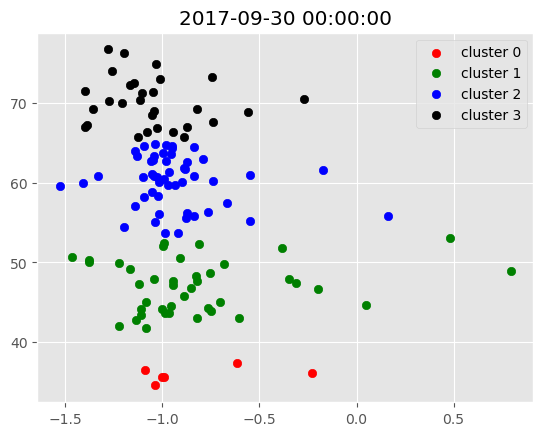

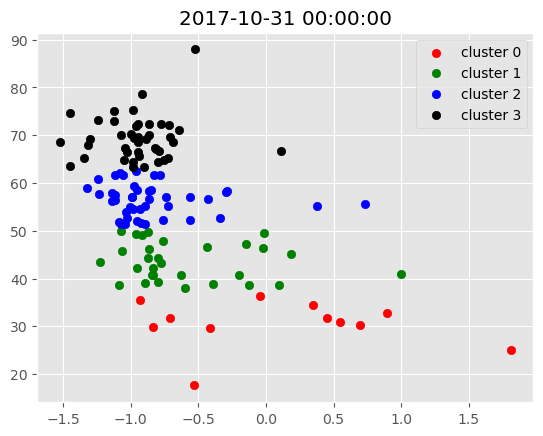

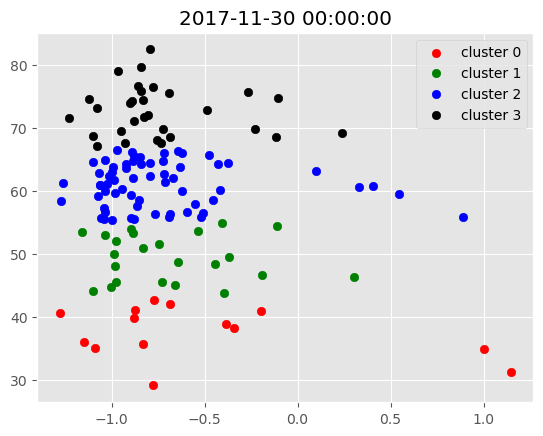

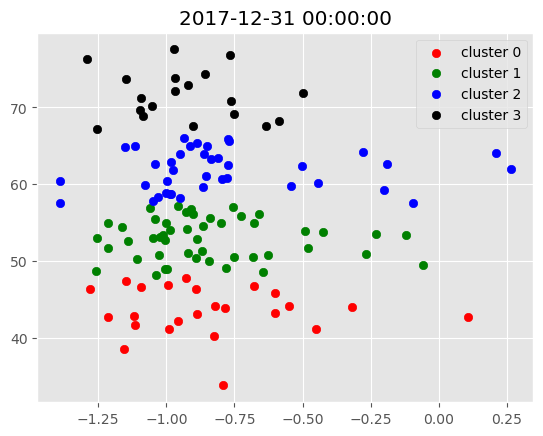

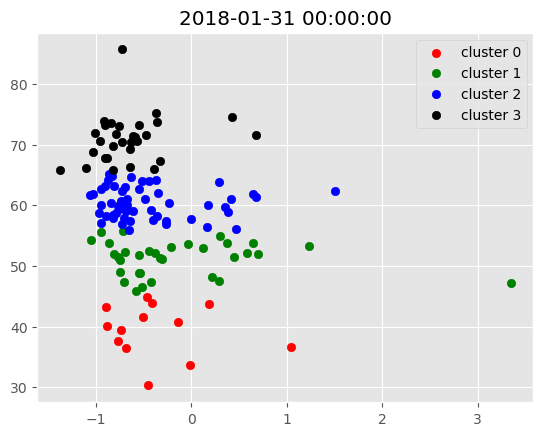

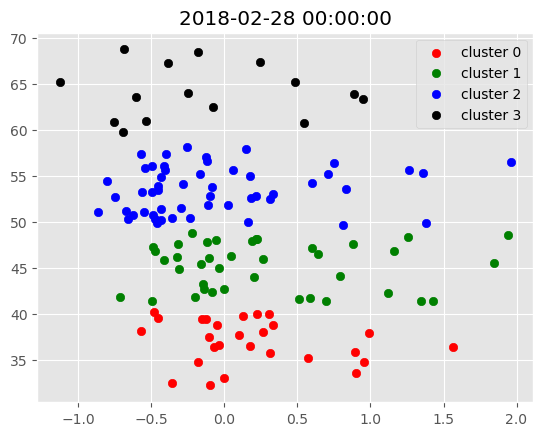

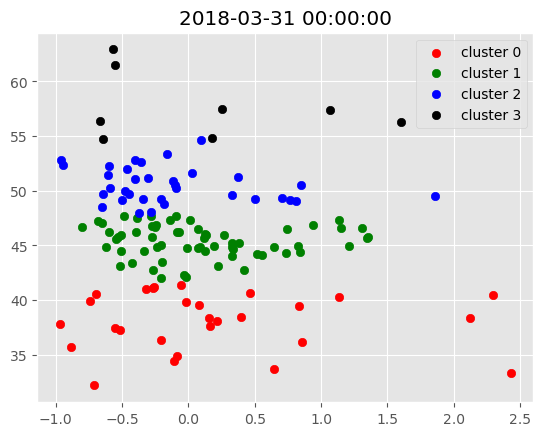

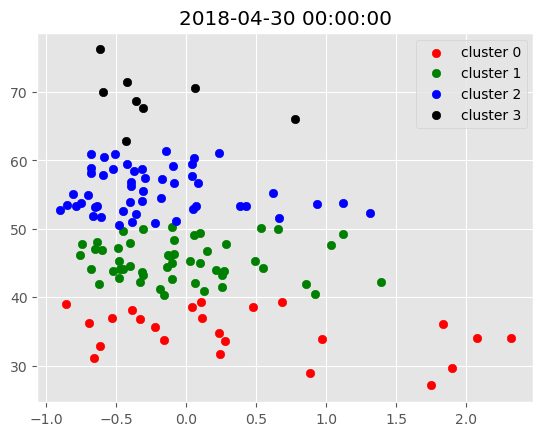

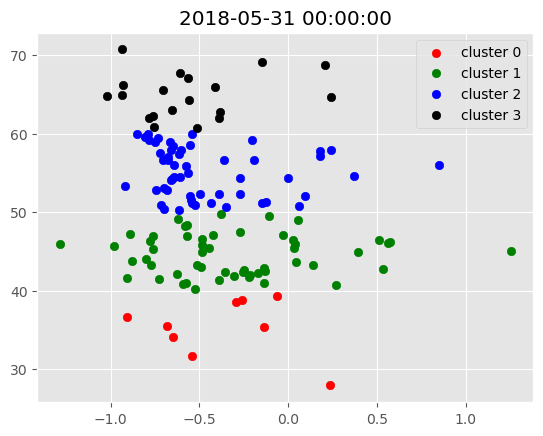

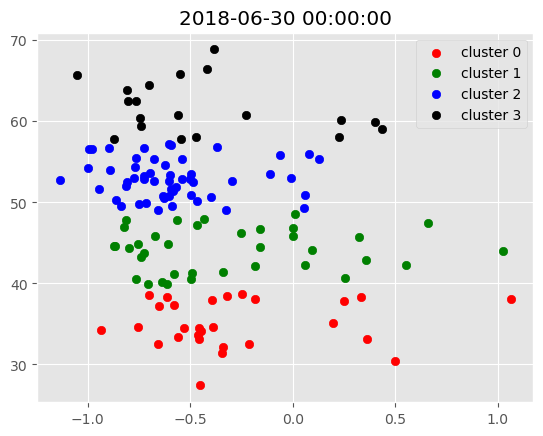

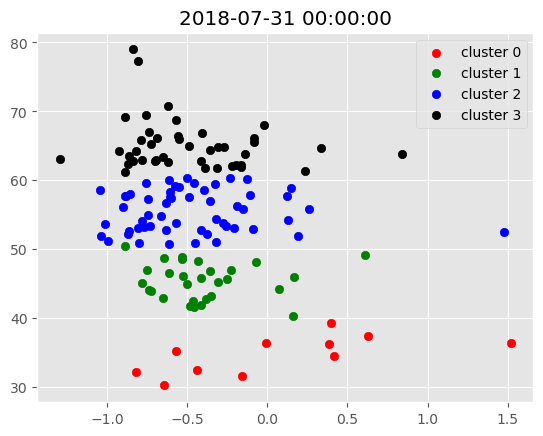

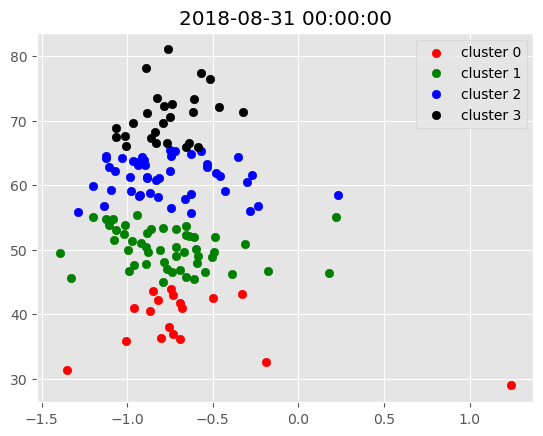

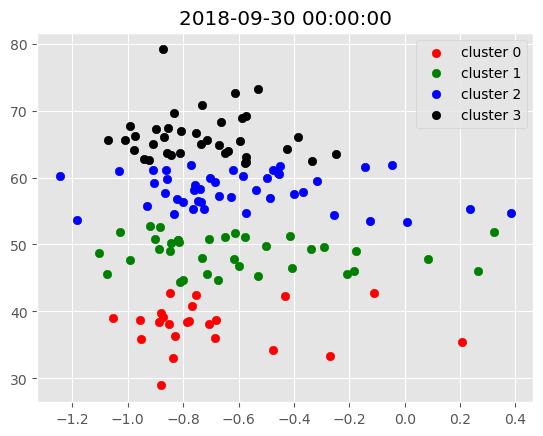

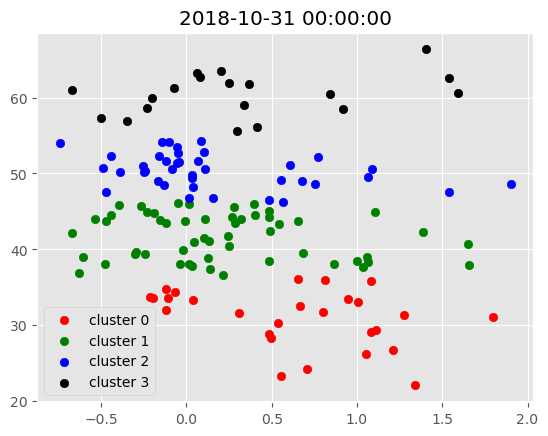

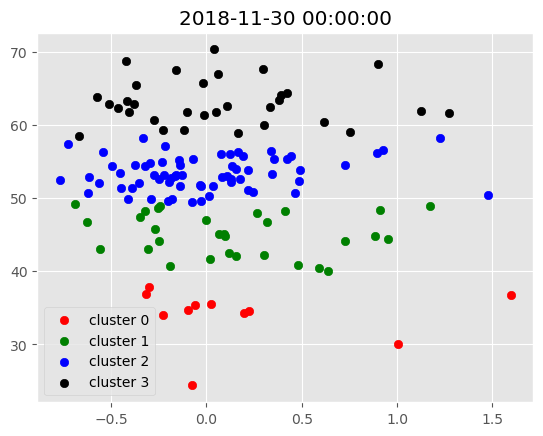

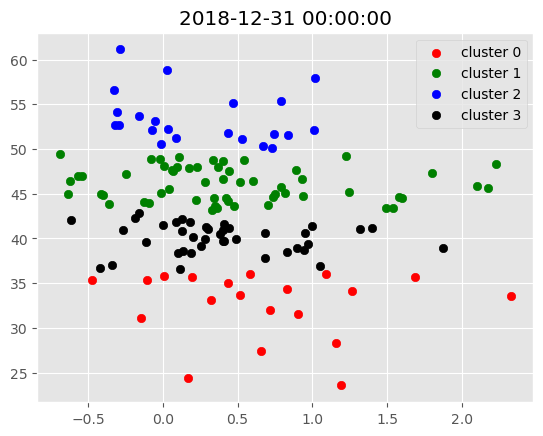

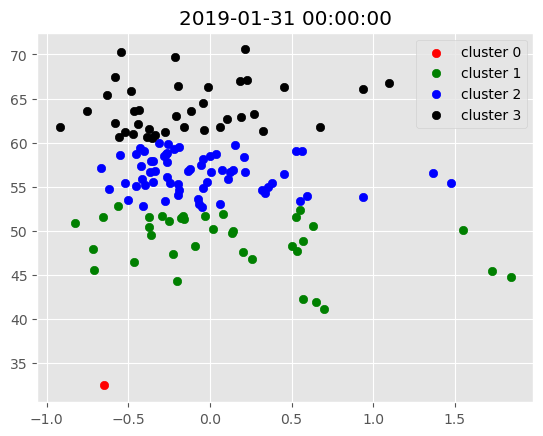

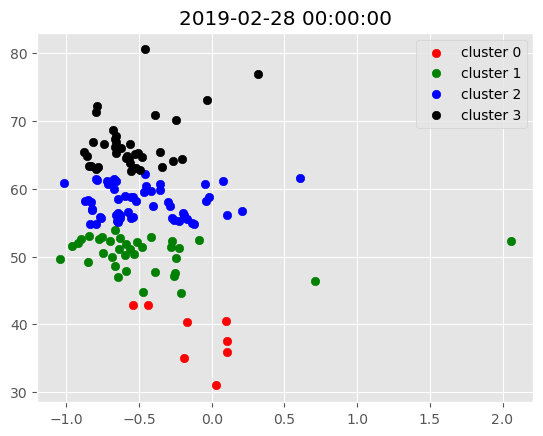

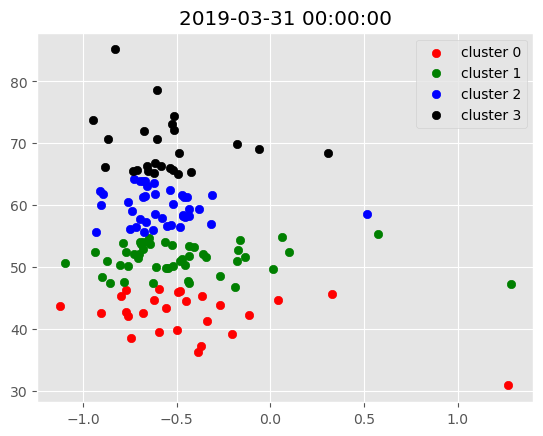

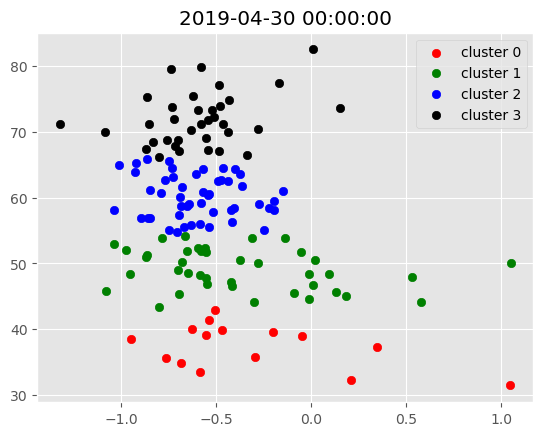

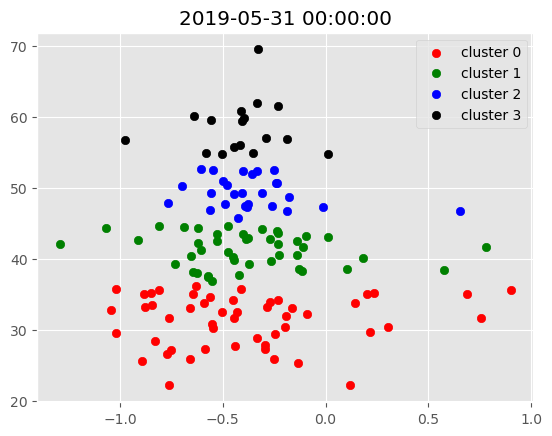

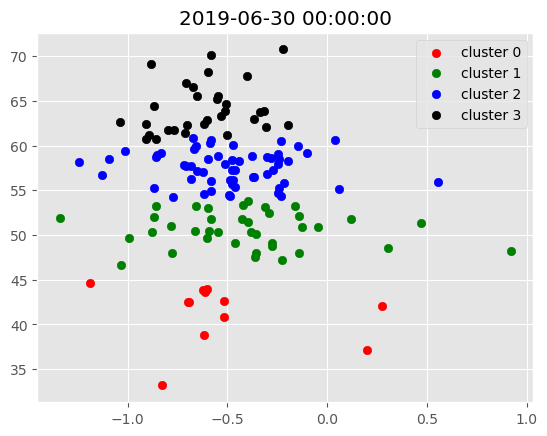

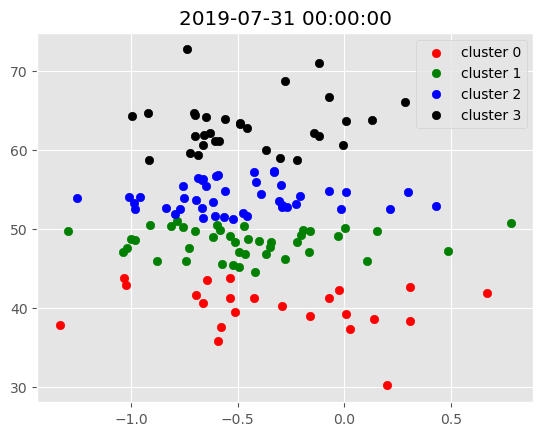

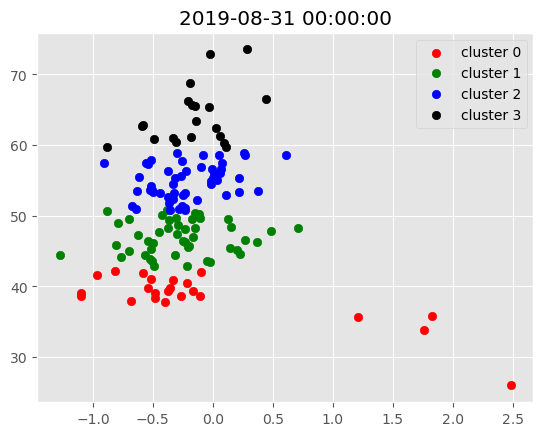

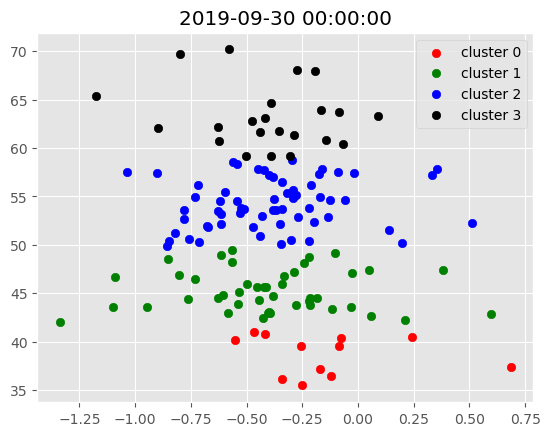

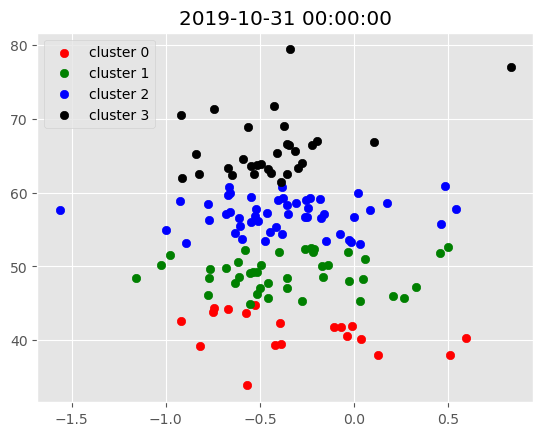

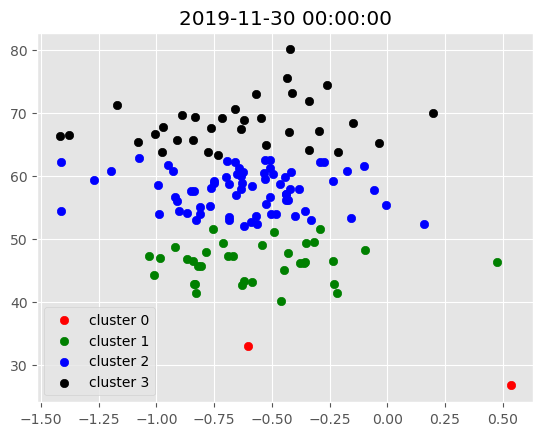

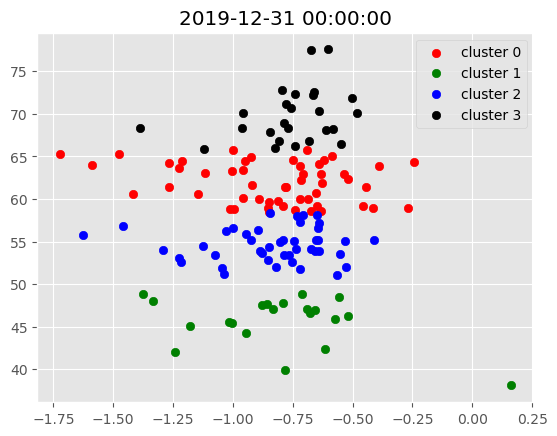

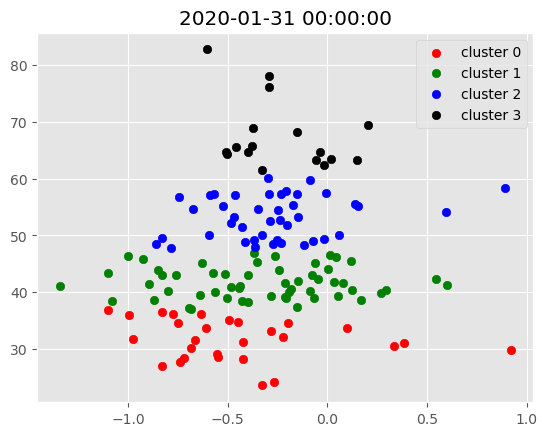

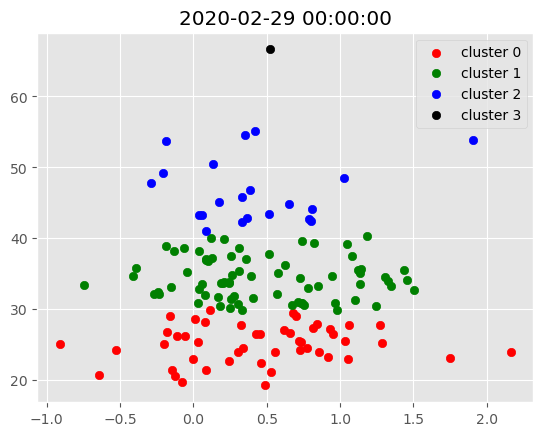

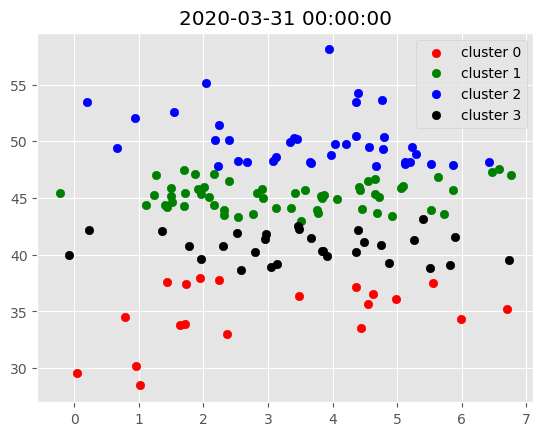

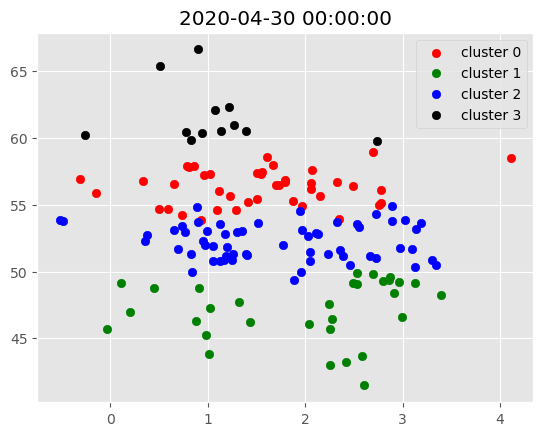

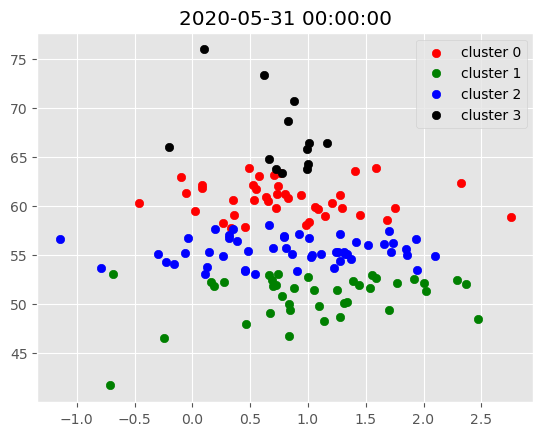

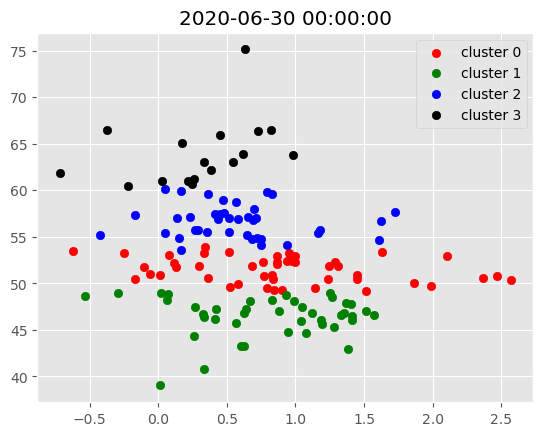

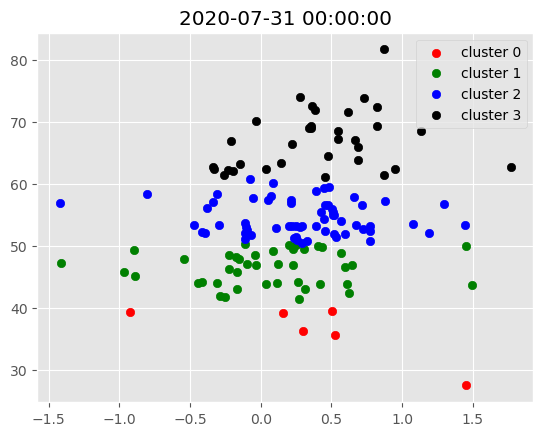

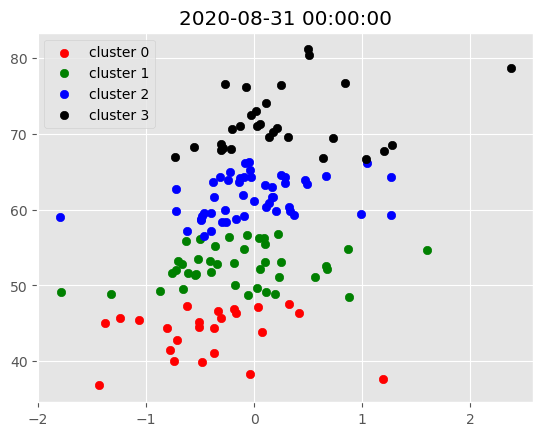

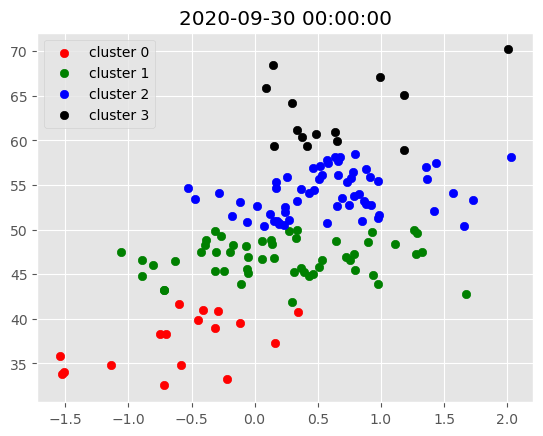

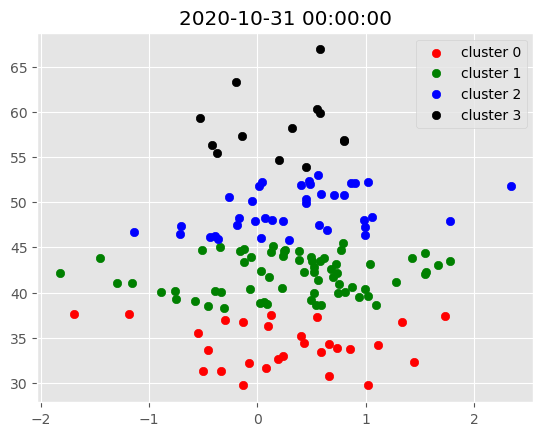

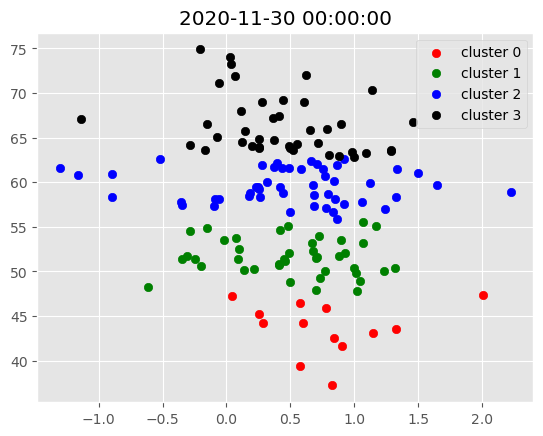

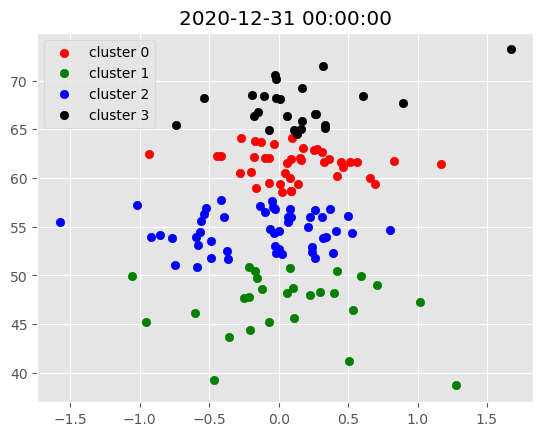

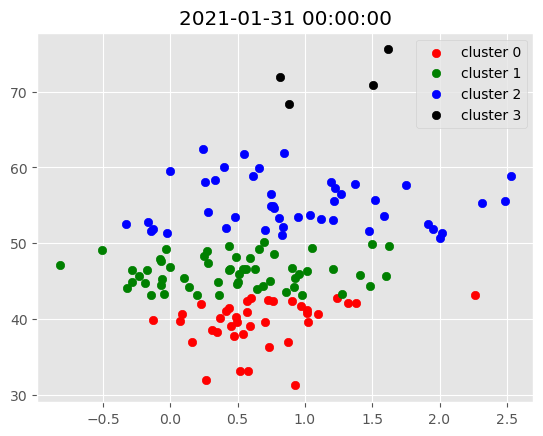

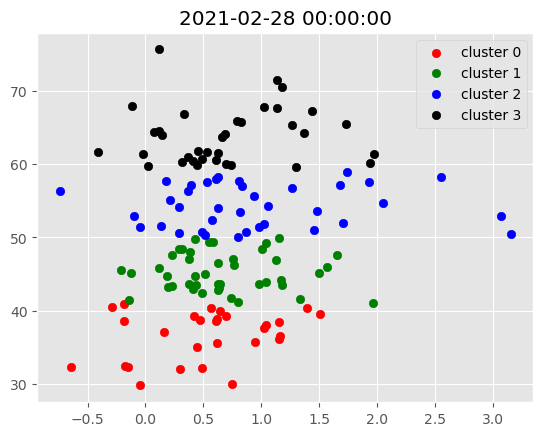

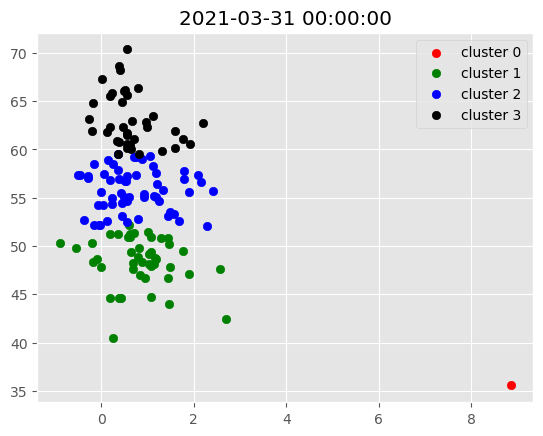

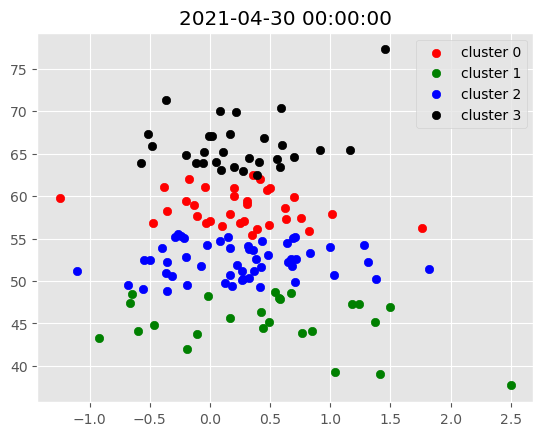

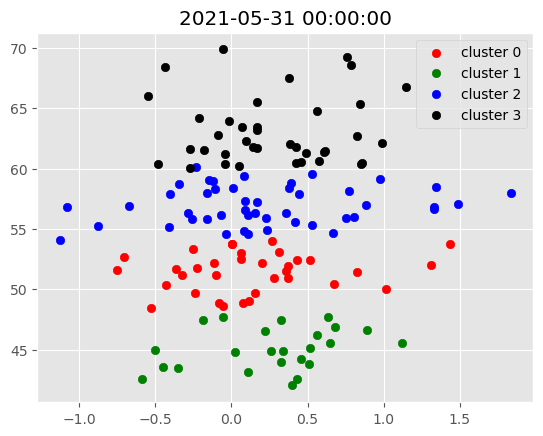

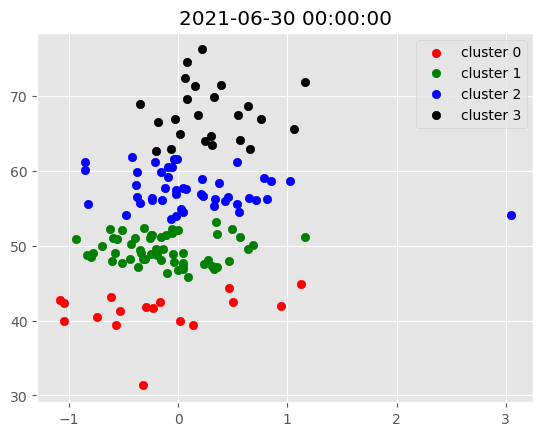

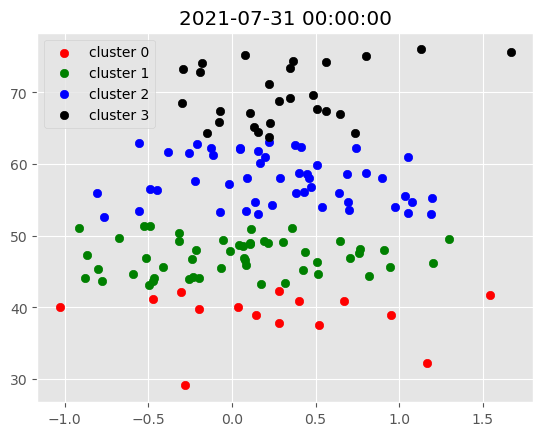

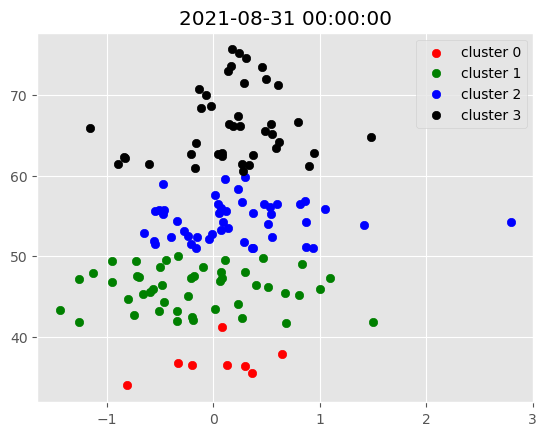

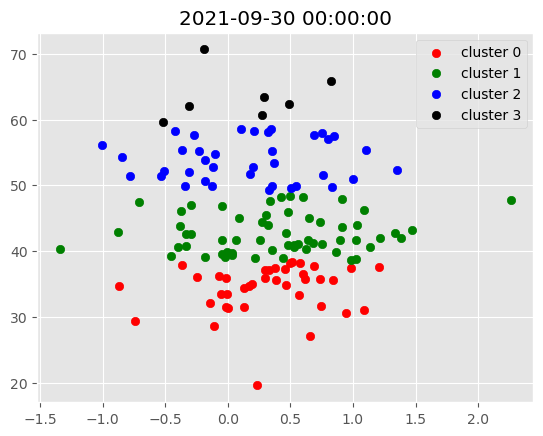

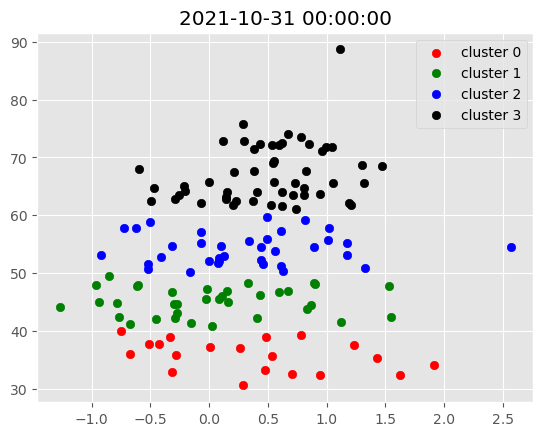

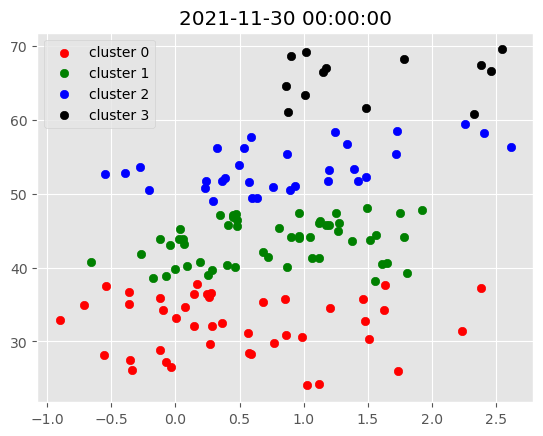

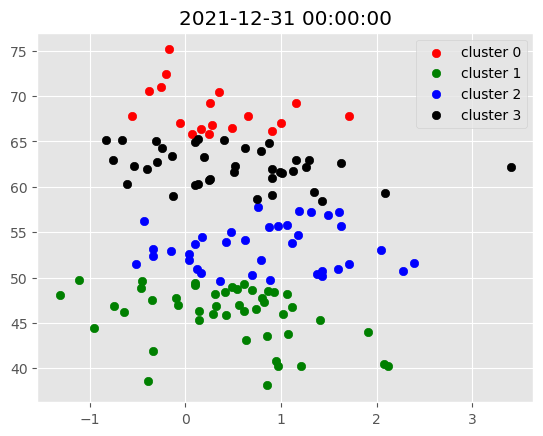

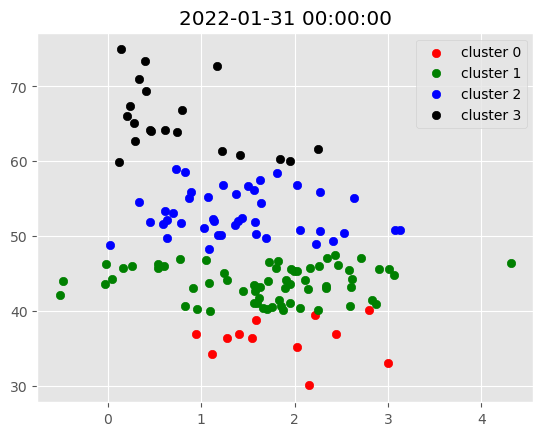

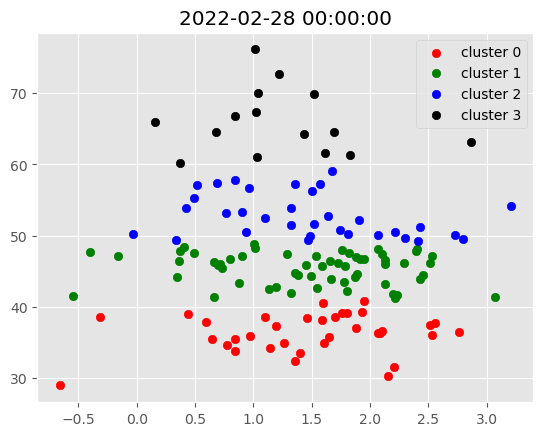

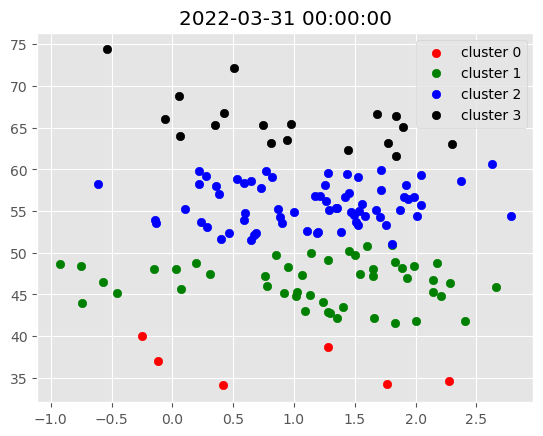

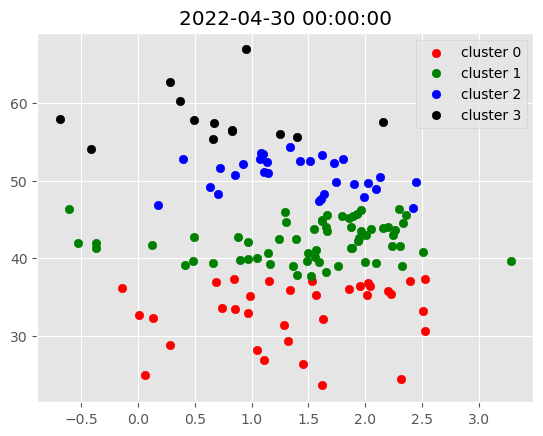

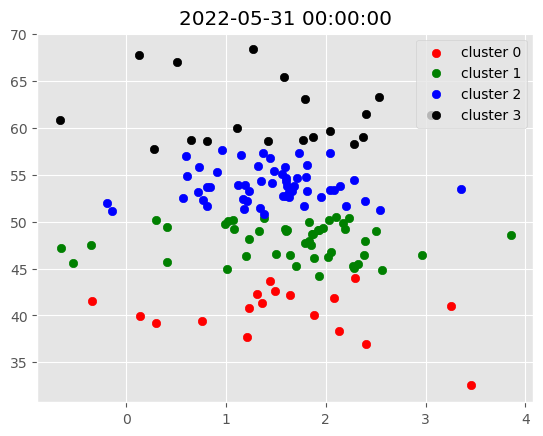

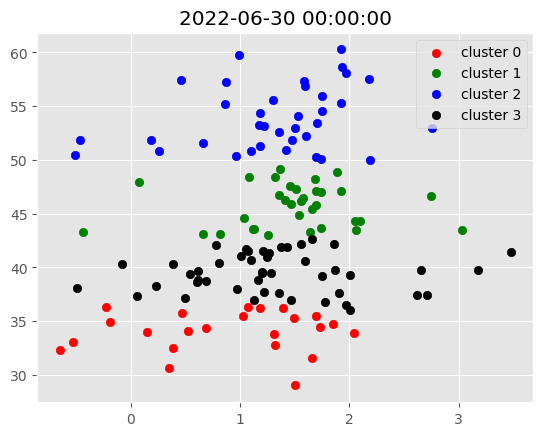

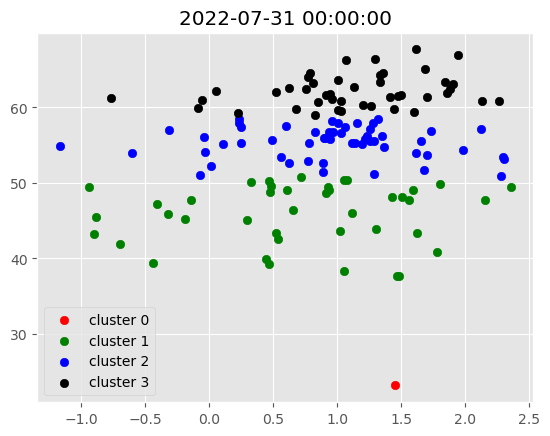

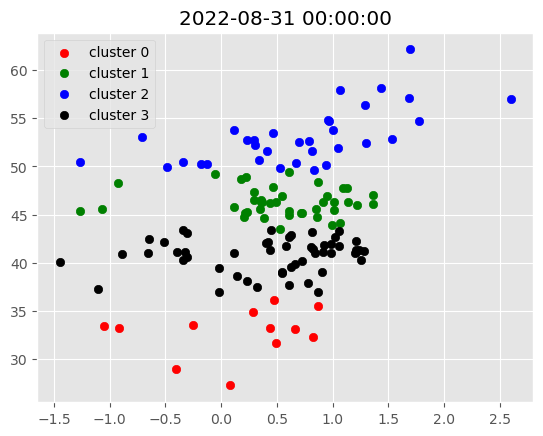

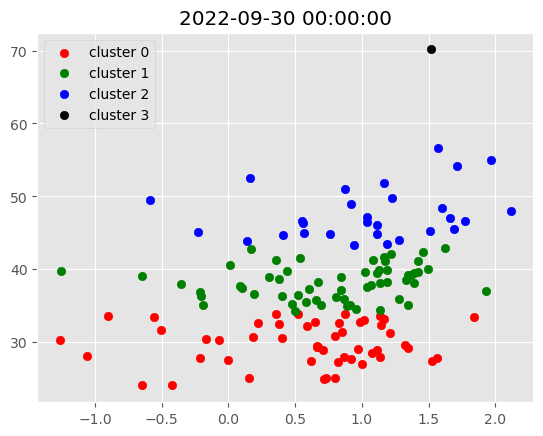

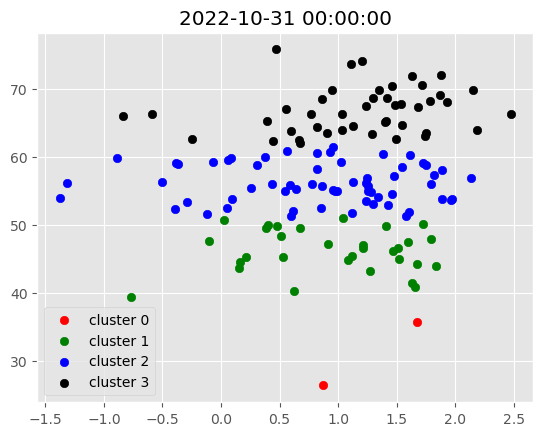

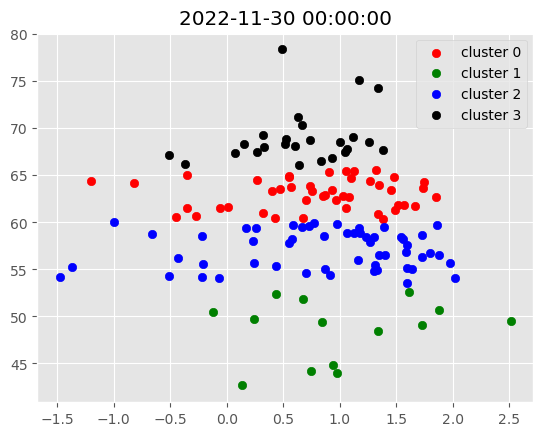

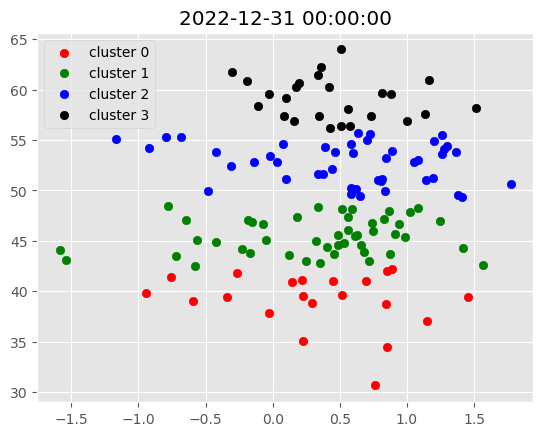

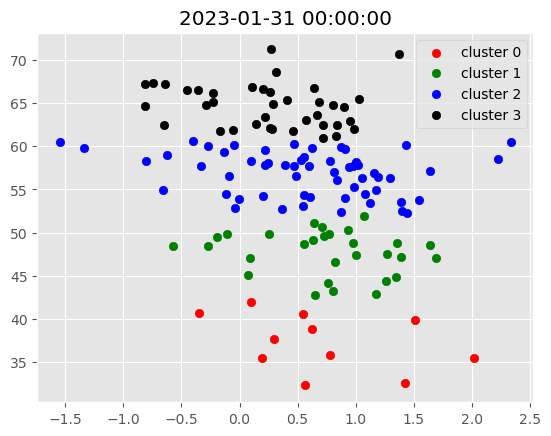

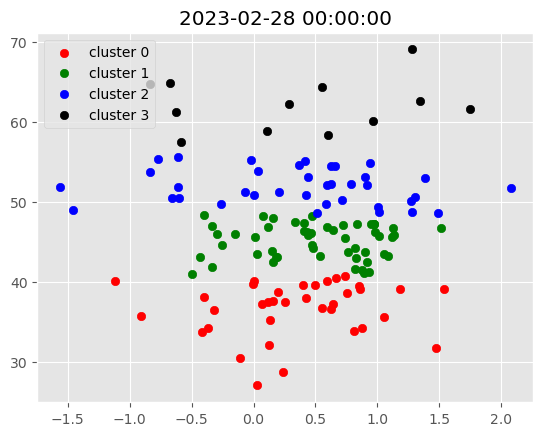

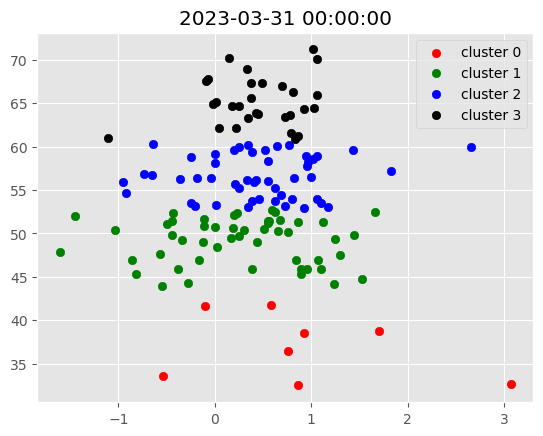

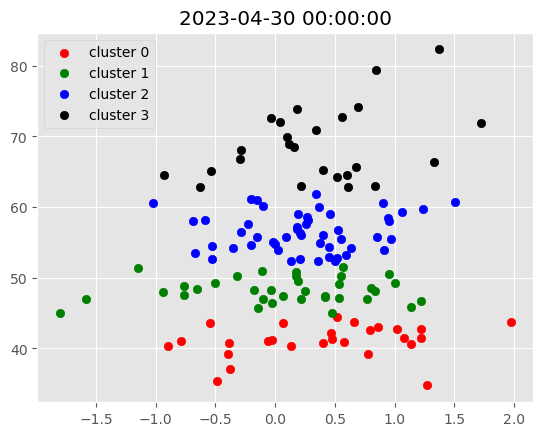

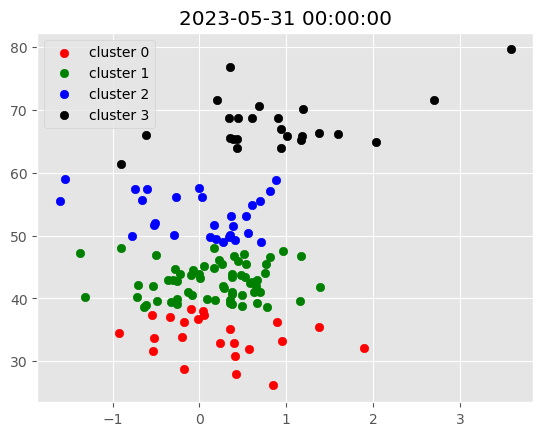

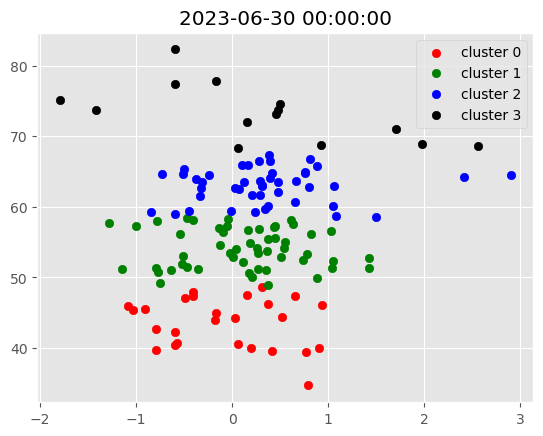

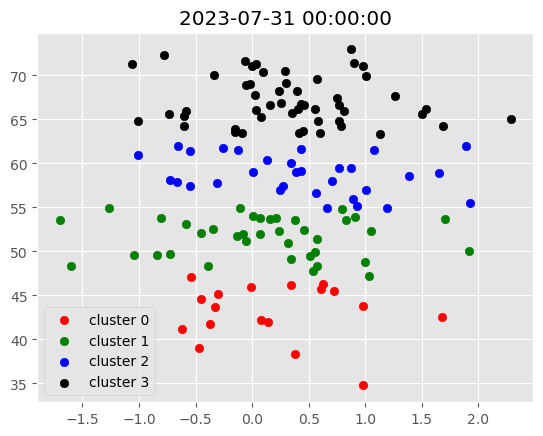

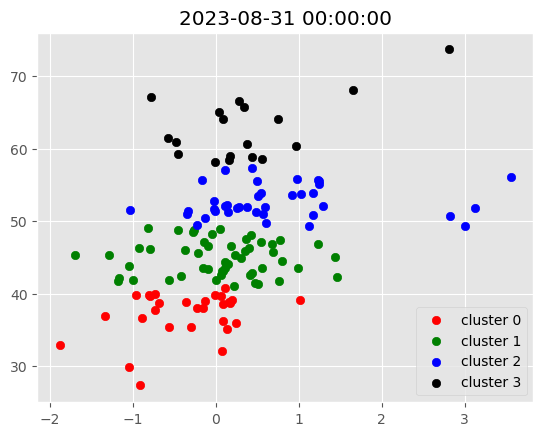

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'{i}')
    
    plotClusters(g)

# 7. For each month choose assets based on K-Means Clusters and make a portfolio based on efficient frontier max sharpe ratio optimization

- Choose stocks clustered around the RSI 70 centroid

In [14]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-10-01': ['ABBV',
  'AMAT',
  'AXP',
  'BA',
  'BMY',
  'C',
  'CAT',
  'COP',
  'CVX',
  'DLTR',
  'EOG',
  'F',
  'FDX',
  'GM',
  'HAL',
  'HD',
  'INTC',
  'MAR',
  'MET',
  'MU',
  'OXY',
  'SCHW',
  'SLB',
  'TXN',
  'UNP',
  'UPS',
  'VLO',
  'WFC',
  'XOM'],
 '2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BLK',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['BA',
  'CAT',
 

## Define portfolio optimization function

- Optimize portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimizeWeights(prices, lowerBound):
    
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    
    cov = risk_models.sample_cov(prices, 252)
    
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lowerBound, .1), solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [16]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks, start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  153 of 153 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2016-09-30  35.288364   26.202578   45.945004   37.085949  108.544632   
2016-10-03  36.339031   26.079733   46.061562   37.313953  107.380737   
2016-10-04  36.271553   26.190987   45.894028   36.919327  105.052940   
2016-10-05  36.502880   26.202578   46.178123   37.480572  105.026299   
2016-10-06  36.792053   26.397270   45.770180   37.682270  105.301704   
...               ...         ...         ...         ...         ...   
2023-08-24  14.570000  176.380005  145.176865  103.178833  312.842499   
2023-08-25  14.580000  178.610001  145.236267  103.636299  317.443420   
2023-08-28  14.730000  180.190002  145.968918  102.224121  319.584534   
2023-08-29  14.900000  184.119995  146.127335  103.298180  322.114044   
2023-08-30  14.770000  187.649994  146.850113  103.835205  321.914856   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-09-30  108.540001   76.122711   72.330002  49.292885   27.741913  ...   
2016-10-03  108.449997   75.630760   71.180000  48.943996   27.530289  ...   
2016-10-04  108.389999   75.233757   71.419998  49.076912   27.245045  ...   
2016-10-05  108.800003   75.587593   73.209999  49.758080   27.548689  ...   
2016-10-06  108.559998   75.570328   72.830002  49.799606   27.502682  ...   
...                ...         ...         ...        ...         ...  ...   
2023-08-24  512.429993  248.556229  208.600006  57.745197  142.520004  ...   
2023-08-25  525.059998  251.790054  215.919998  57.506618  144.360001  ...   
2023-08-28  529.919983  253.123367  217.089996  57.526501  145.419998  ...   
2023-08-29  540.570007  253.083572  219.399994  58.003651  149.979996  ...   
2023-08-30  545.359985  253.660675  221.550003  57.993713  150.949997  ...   

             Volume                                                           \
                  V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2016-09-30  9776800  8318600  2545700  13077600   4490200  4396800  54117700   
2016-10-03  8155400  5172200  1371300   9120300   2306200  5163900  38197700   
2016-10-04  5772000  5804000  1081100  13753300   3111600  4601200  44008300   
2016-10-05  6163400  6393900   964400  17190900   2498200  4442000  40459000   
2016-10-06  7687100  4045600  1375000  11724000   3661700  4964600  29878200   
...             ...      ...      ...       ...       ...      ...       ...   
2023-08-24  4570700  2764700   704400  18561400  13169200  1922800  10363300   
2023-08-25  3541500  5167200   697900  14912100  10937800  2659600  12534700   
2023-08-28  3741500  2680100   552500  16050400   8282300  4268500  10314500   
2023-08-29  3975600  3041800   882600  28782800   6892600  2310600  14404800   
2023-08-30  4573300  3167900   640500  15021400   5883700  3508800  12536300   

                                         
                 WMT     WYNN       XOM  
Date                                     
2016-09-30   9982600  6737900  15961500  
2016-10-03   5857700  4234900   7111200  
2016-10-04   6569300  3288400   8222000  
2016-10-05   6464400  2699600   8796200  
2016-10-06  20110300  1969200   7718300  
...              ...      ...       ...  
2023-08-24   4677700  1494000  10818500  
2023-08-25   4089000  1706200  13579300  
2023-08-28   3957000  1209800  10382100  
2023-08-29   4234100  1082900   9665000  
2023-08-30   3655900  1263500  11922100  

[1740 rows x 918 columns]

- Calculate daily return of each stock
- Loop over each month, select stocks for month and calculate amount to invest in the stock for the next month
- If maximum sharpe ratio optimization fails, apply equal weighting for investments
- Calculate daily return

In [17]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True, right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted return'].sum().to_frame('Machine Learning Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-02-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-09-01, Continuing with Equal Weights
Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal Weights

,Machine Learning Return
date,
2017-10-02,0.005351
2017-10-03,0.000964
2017-10-04,-0.000292
2017-10-05,0.003496
2017-10-06,0.001304
...,...
2023-08-24,-0.013961
2023-08-25,0.005740
2023-08-28,0.009034


# 8. Compare Portfolio Returns to S&P 500 Returns

In [18]:
spy = yf.download(tickers='SPY', start='2015-01-01', end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Return'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Machine Learning Return,SPY Return
2017-10-02,0.005351,0.004330
2017-10-03,0.000964,0.002138
2017-10-04,-0.000292,0.001186
2017-10-05,0.003496,0.005908
2017-10-06,0.001304,-0.001139
...,...,...
2023-08-24,-0.013961,-0.013956
2023-08-25,0.005740,0.007025
2023-08-28,0.009034,0.006321
2023-08-29,0.014375,0.014351


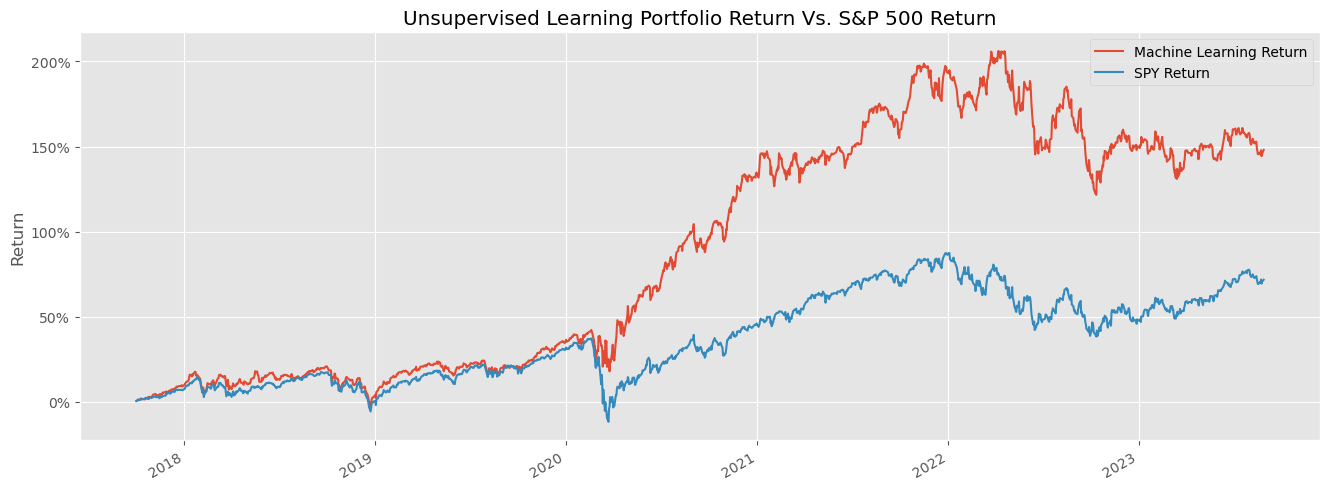

In [19]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-08-28'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Portfolio Return Vs. S&P 500 Return')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()